In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
  !pip install unsloth
else:
  # Do this only in Colab notebooks! Otherwise use pip install unsloth
  !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
  !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
  !pip install --no-deps unsloth

In [2]:
# 加载unsloth
from unsloth import FastLanguageModel
import torch

# 设置模型参数
max_seq_length = 2048 # 选择序列最大长度，unsloth内部自动支持RoPE缩放
dtype = None # 自动检测数据类型。Tesla T4、V100上使用Float16，Ampere+架构上使用Bfloat16
load_in_4bit = True # 使用4位量化以减少内存使用，可以设为False关闭量化

# 从预训练模型加载FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = "unsloth/Qwen2.5-7B",
  max_seq_length = max_seq_length,      # 设置之前定义的最大序列长度
  dtype = dtype,               # 设置之前定义的数据类型
  load_in_4bit = load_in_4bit,        # 设置是否使用4位量化
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/106k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [3]:
# 继续添加一个LoRA Adapters, 冻结参数只微调1%-10%的权重
model = FastLanguageModel.get_peft_model(
  model,                          # 传入之前加载的基础模型
  r = 16,                         # LoRA秩参数，值越大模型可塑性越高，建议值为8、16、32、64、128
                                # 该参数决定了LoRA适配器的复杂度
  target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
                                        # 指定需要应用LoRA的模块
                                        # 这里选择了注意力机制的投影层和MLP层作为微调目标
                                        # q_proj/k_proj/v_proj/o_proj: 注意力机制的查询/键/值/输出投影层
                                        # gate_proj/up_proj/down_proj: MLP网络中的门控/上投影/下投影层
  lora_alpha = 16,                # LoRA缩放参数，通常设置为与r相同或更大，控制LoRA更新对原始权重的影响程度
  lora_dropout = 0,               # LoRA的丢弃率，0表示不使用dropout，设为0可获得最佳性能优化
  bias = "none",                  # 是否训练偏置参数，"none"表示不训练偏置，设为"none"可获得最佳性能优化
  use_gradient_checkpointing = "unsloth",      # 梯度检查点设置，可选值为True或"unsloth"，"unsloth"是优化版本，比标准梯度检查点更高效
  random_state = 42,            # 随机数种子，确保实验可重复性
  use_rslora = False,             # 是否使用秩稳定化LoRA(Rank Stabilized LoRA)，默认不启用，启用后可提高模型训练稳定性
  loftq_config = None,            # LoftQ配置，用于低位精度量化训练，默认不启用
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


这里用的是Empatyhetic_dialogue数据集，做一下数据清洗

huggingface:Estwld/empathetic_dialogues_llm

In [4]:
from datasets import load_dataset

train_dataset = load_dataset("dair-ai/emotion", split="train")
eval_dataset = load_dataset("dair-ai/emotion", split="validation")

emo_dict= {
  0:"sadness",
  1:"joy",
  2:"love",
  3:"anger",
  4:"fear",
  5:"surprise",
}

prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
There are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    inputs = examples["text"]
    outputs = examples["label"]
    texts = []
    for input, output in zip(inputs, outputs):
        emotion_word = emo_dict[output]
        text = prompt.format(input, emotion_word) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}


train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)


# empathetic_prompt = """
# ### Instruction:
# Recognize the emotion from the input. Your should follow the Response format, including a word describing the user's emotion and a reply(No more than 30 words).
# your return must have the fomula like this: 【happy】I guess you have the nice weekend.
# ### Input:
# {}
# ### Response:
# 【{}】{}
# """
# def format_empathetic_dialogues(examples):
#   texts = []
#   for conversation, emotion in zip(examples["conversations"], examples["emotion"]):
#     if conversation[-1]["role"] == "user":
#       continue
#     for i in range(0, len(conversation) - 1, 2):
#       if i+1 < len(conversation) and conversation[i]["role"] == "user" and conversation[i+1]["role"] == "assistant":
#         user_message = conversation[i]["content"]
#         assistant_message = conversation[i+1]["content"]
#         formatted_text = empathetic_prompt.format(
#             user_message,
#             emotion,
#             assistant_message
#         ) + EOS_TOKEN
#         texts.append(formatted_text)

#   return {"text": texts}

# train_dataset = train_dataset.map(format_empathetic_dialogues, batched=True, remove_columns=train_dataset.column_names)
# eval_dataset = eval_dataset.map(format_empathetic_dialogues, batched=True, remove_columns=eval_dataset.column_names)


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
print(train_dataset[:1]["text"])
print(eval_dataset[:1]["text"])

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nThere are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.\n\n### Input:\ni didnt feel humiliated\n\n### Response:\nsadness<|endoftext|>']
['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nThere are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.\n\n### Input:\nim feeling quite sad and sorry for myself but ill snap out of it soon\n\n### Response:\nsadness<|endoftext|>']


In [6]:
from trl import SFTConfig, SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        # per_device_eval_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        num_train_epochs = 1,
        # eval_strategy = "steps",
        # eval_steps = 10,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",
    ),
    # args = SFTConfig(packing=True),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/16000 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [7]:
import wandb
# wandb.login()
# wandb.init()
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 1 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 1315111913 (1315111913-lingnan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,2.036700
2,2.340800
3,1.928700
4,1.998300
5,2.036400
6,1.859200
7,1.755300
8,1.719200
9,1.573600
10,1.260400


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
state = trainer.evaluate()
state

Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


{'eval_loss': 0.7853544354438782,
 'eval_runtime': 106.5233,
 'eval_samples_per_second': 18.775,
 'eval_steps_per_second': 2.347}

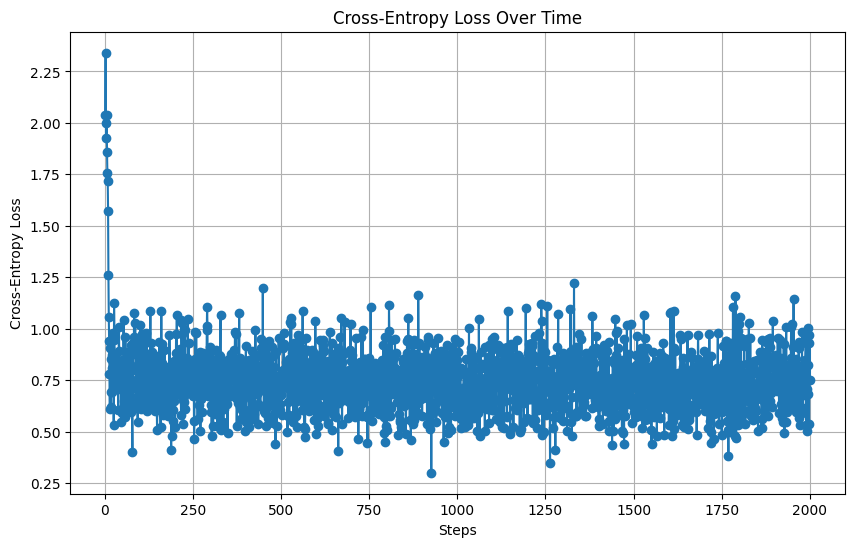

In [8]:
trainer_stats
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# Extract loss values
training_loss = []
train_steps = []
val_loss = []
val_steps = []

for log in logs:
  if "loss" in log and "eval_loss" not in log:
    training_loss.append(log["loss"])
    train_steps.append(log["step"])
  elif "eval_loss" in log:
    val_loss.append(log["eval_loss"])
    val_steps.append(log["step"])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, training_loss, label="Train Loss", marker="o")
plt.plot(val_steps, val_loss, label="Validation Loss", marker="x")
plt.title('Cross-Entropy Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.savefig('training_and_evaluate_loss.png')
plt.show()

In [9]:
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

In [ ]:
!zip -r lora_model.zip lora_model

  adding: lora_model/ (stored 0%)
  adding: lora_model/tokenizer.json (deflated 81%)
  adding: lora_model/README.md (deflated 66%)
  adding: lora_model/adapter_config.json (deflated 56%)
  adding: lora_model/adapter_model.safetensors (deflated 8%)
  adding: lora_model/special_tokens_map.json (deflated 68%)
  adding: lora_model/tokenizer_config.json (deflated 89%)
  adding: lora_model/vocab.json (deflated 61%)
  adding: lora_model/added_tokens.json (deflated 67%)
  adding: lora_model/merges.txt (deflated 57%)


In [10]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit
    )
    FastLanguageModel.for_inference(model)



==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# 性格识别测试
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Then there are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.

### Input:
{}

### Response:
{}"""

inputs = tokenizer(
[
    prompt.format(
        "He actually stole my business. It really pissed me off！！！！",
        "", # output
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Then there are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.

### Input:
He actually stole my business. It really pissed me off！！！！

### Response:
anger<|endoftext|>


In [15]:
# 对话能力测试
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a gentle and lovely voice assistant, you need to give responses based on input.
### Input:
{}

### Response:
{}"""

inputs = tokenizer(
[
    prompt.format(
        # "He actually stole my business. It really pissed me off！！！！",
        "so,what do you like to do in weekend?",
        "", # output
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a gentle and lovely voice assistant, you need to give responses based on input.
### Input:
so,what do you like to do in weekend?

### Response:
i like to go to the park and play with my friends<|endoftext|>


In [38]:
# 额外测试分块功能。
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a master of imitation. You need to insert some of the following sound effects【uh,(long-break),um,(laugh),(cough),(lip-smacking),(sigh)】 into the context to make it sound more in line with the input emotion.
EXAMPLE:context:You are intresting! emotion:joy --->  (laugh)You are intresting!
### Input:
context:{} emotion:{}

### Response:
{}"""

inputs = tokenizer(
[
    prompt.format(
        "Today is so hard. I really don't want to go to work at all.",
        "sad",
        ""
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a master of imitation. You need to insert some of the following sound effects【uh,(long-break),um,(laugh),(cough),(lip-smacking),(sigh)】 into the context to make it sound more in line with the input emotion.
EXAMPLE:context:You are intresting! emotion:joy --->  (laugh)You are intresting!
### Input:
context:Today is so hard. I really don't want to go to work at all. emotion:sad

### Response:
(um)Today is so hard. I really don't want to go to work at all.<|endoftext|>


In [21]:
# 测试集测试
from datasets import load_dataset

eval_dataset = load_dataset("dair-ai/emotion", split="test")

def text_dunc(input,emotion):
  prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  Then there are five types: anger, fear, joy, love, sadness, and surprise. You need to determine which category the emotion of input belongs to and return.

  ### Input:
  {}

  ### Response:
  {}"""
  inputs = tokenizer(
  [
      prompt.format(
          input,
          "", # output
      )
  ], return_tensors = "pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=128)
  input_length = inputs["input_ids"].shape[1]
  generated_tokens = outputs[0][input_length:]
  generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
  # print(generated_text)
  if generated_text.strip() == emotion:
    return True
  else:
    return False

emo_dict= {
  0:"sadness",
  1:"joy",
  2:"love",
  3:"anger",
  4:"fear",
  5:"surprise",
}
all_example = 0
error = 0
correct = 0
for data in eval_dataset:
  all_example += 1
  if text_dunc(data["text"],emo_dict[data["label"]]):
    correct += 1
  else:
    error += 1

print(f"Accuracy:{correct/all_example:.2f}")

Accuracy:0.87


In [16]:
# 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# 16bit GGUF
if False: model.save_pretrained_gguf("model_qwen2.5_7b_16bit", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# q4_k_m GGUF
if True: model.save_pretrained_gguf("model_qwen2.5_7b_q4_k_m", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("", tokenizer, quantization_method = "q4_k_m", token = "")

# multiple GGUF options
if False:
    model.push_to_hub_gguf(
        "hf/model",
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 7.5G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 61.22 out of 83.48 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 45.78it/s]


Unsloth: Saving tokenizer... Done.
Done.


Unsloth: Converting qwen2 model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at model_qwen2.5_7b_q4_k_m into bf16 GGUF format.
The output location will be /content/model_qwen2.5_7b_q4_k_m/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: model_qwen2.5_7b_q4_k_m
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'model-00001-of-00004.safetensors'
INFO:hf-to-gguf:token_e

In [ ]:
!zip -r KAIchengzk.zip KAIchengzk

  adding: KAIchengzk/ (stored 0%)
  adding: KAIchengzk/emorobotion/ (stored 0%)
  adding: KAIchengzk/emorobotion/tokenizer.json (deflated 81%)
  adding: KAIchengzk/emorobotion/config.json (deflated 50%)
  adding: KAIchengzk/emorobotion/unsloth.Q4_K_M.gguf (deflated 2%)
  adding: KAIchengzk/emorobotion/unsloth.BF16.gguf (deflated 23%)
  adding: KAIchengzk/emorobotion/generation_config.json (deflated 36%)
  adding: KAIchengzk/emorobotion/special_tokens_map.json (deflated 68%)
  adding: KAIchengzk/emorobotion/tokenizer_config.json (deflated 89%)
  adding: KAIchengzk/emorobotion/vocab.json (deflated 61%)
  adding: KAIchengzk/emorobotion/added_tokens.json (deflated 67%)
  adding: KAIchengzk/emorobotion/model.safetensors


zip error: Interrupted (aborting)
